In [ ]:
# import packages
import h5py
import numpy as np
import torch
from mirtorch.linear import NuSense, Diag, Diff3dgram
from mirtorch.alg.cg import CG

# select device
if torch.cuda.is_available():
    print('CUDA is available')
    device0 = torch.device('cuda:2')
else:
    print('CUDA is not available')
    device0 = torch.device('cpu')

CUDA is available - using GPU


In [2]:
# load in the data
fname = '/home/djfrey/data/lps_multicoil_testing/lps_data_acr_bodycoil.h5'

with h5py.File(fname, 'r') as h5_file:
    kdata = h5_file['kdata/real'][:] + 1j * h5_file['kdata/imag'][:] # kspace data
    k_in = h5_file['ktraj/spoke_in'][:] # spoke in trajectory (1/cm)
    k_out = h5_file['ktraj/spoke_out'][:] # spoke out trajectory (1/cm)
    fov = h5_file['seq_args/fov'][0][0] # fov (cm)
    N = int(h5_file['seq_args/N'][0][0]) # 3D matrix size
    nseg = int(h5_file['seq_args/nseg'][0][0]) # number of samples per segment
    nspokes = int(h5_file['seq_args/nspokes'][0][0]) # number of spokes (rf excitations)
    nprj = int(h5_file['seq_args/nprj'][0][0]) # number of projections
    nint = int(h5_file['seq_args/nint'][0][0]) # number of interleaves
    nrep = int(h5_file['seq_args/nrep'][0][0]) # number of repetitions
    ncoil = 1 # number of coils

# convert to tensors and send to device
kdata = torch.tensor(kdata).reshape(1,ncoil,nseg*nspokes*nprj)
k_in = torch.tensor(k_in).reshape(3,nseg*nspokes*nprj)
k_out = torch.tensor(k_out).reshape(3,nseg*nspokes*nprj)

In [14]:
# convert to radians
om_in = 2*torch.pi * fov/N * k_in.to(device0)
om_out = 2*torch.pi * fov/N * k_out.to(device0)

# create filter objects
cutoff = 0.8
Hvec_in = 1*(torch.norm(om_in,2,dim=0) <= cutoff*torch.pi).to(device0).unsqueeze(0).unsqueeze(0)
Hvec_out = 1*(torch.norm(om_out,2,dim=0) <= cutoff*torch.pi).to(device0).unsqueeze(0).unsqueeze(0)
H_in = Diag(Hvec_in)
H_out = Diag(Hvec_out)

# create nufft system operators with flat sensitivity
smap = torch.ones(1,1,N,N,N).to(kdata).to(device0)
F_in = NuSense(smap, om_in)
F_out = NuSense(smap, om_out)

# set up system matrices and data
A = H_in*F_in + H_out*F_out
AHA = A.H*A

# add L2 roughness penalty
lam = 0.01
THT = Diff3dgram(F_in.size_in)
AHA_tikh = AHA + lam*THT

# set up data
y = kdata[:, 0:1, :].to(device0)
AHy = A.H*y

In [15]:
# solve with CG, explicitly defined AHA
solv = CG(AHA_tikh, max_iter=30)
x = solv.run(torch.zeros(1,1,N,N,N).to(kdata).to(device0), AHy)

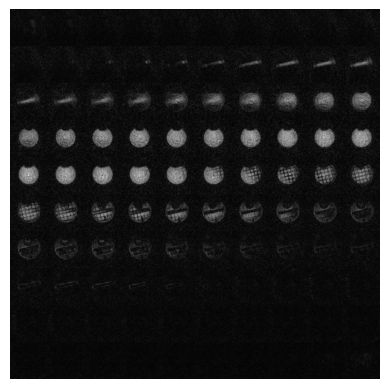

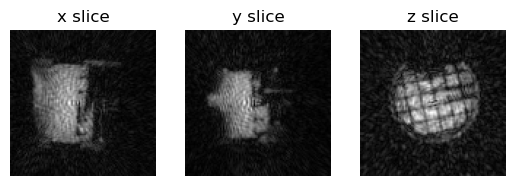

In [16]:
# visualize the results
from vis3d import im
im(np.abs(x.squeeze().cpu().numpy()))
im(np.abs(x.squeeze().cpu().numpy()),viewtype='mid3')